In [11]:
import sys, os
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [12]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import src.eda
from src.eda import calculate_vif

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor
from sklearn.inspection import permutation_importance

import shap

## Model 1: Linear Regression

In [13]:
df_lr = pd.read_csv("../data/df_LR.csv")

In [14]:
df_lr.head()

,guest_capacity,amenities_count,nightly_rate,min_stay_encoded,property_type_Standard Apartment,property_type_Tiny Studio,host_response_time_same day,host_response_time_within an hour,season_peak,season_shoulder,cancellation_policy_moderate,cancellation_policy_strict
0,4,8,187.29,1,True,False,False,True,True,False,False,False
1,3,6,255.64,1,True,False,False,False,False,False,False,False
2,2,10,62.82,0,True,False,True,False,False,False,False,False
3,2,11,203.80,1,True,False,True,False,False,True,False,True
4,4,15,1000.00,3,False,False,True,False,True,False,False,True


In [15]:
X = df_lr.drop(columns=["nightly_rate"])
y = df_lr["nightly_rate"]
X = sm.add_constant(X)
X = X.astype(float)

In [16]:
# Build model

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           nightly_rate   R-squared:                       0.364
Model:                            OLS   Adj. R-squared:                  0.362
Method:                 Least Squares   F-statistic:                     200.3
Date:                Sun, 04 May 2025   Prob (F-statistic):               0.00
Time:                        15:04:46   Log-Likelihood:                -23118.
No. Observations:                3868   AIC:                         4.626e+04
Df Residuals:                    3856   BIC:                         4.634e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

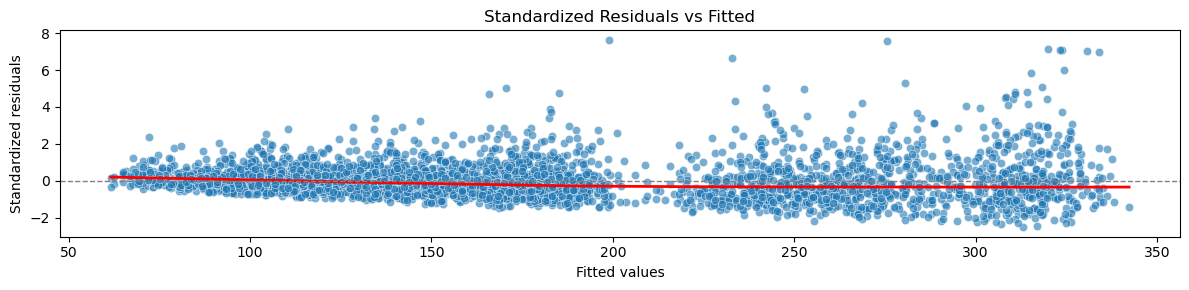

<Figure size 1200x300 with 0 Axes>

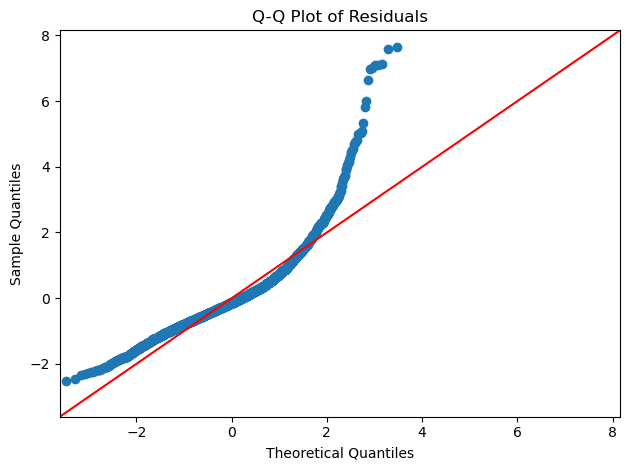

In [17]:
def plot_diagnostics(model, figsize=(12, 6)):

    resid  = model.resid
    fitted = model.fittedvalues

    stand_resid = (resid - np.mean(resid)) / np.std(resid)

    # 1. Residuals vs Fitted
    plt.figure(figsize=(figsize[0], figsize[1] // 2))
    sns.scatterplot(x=fitted, y=stand_resid, alpha=0.6)
    sns.regplot(x=fitted, y=stand_resid,
                scatter=False, lowess=True,
                line_kws={'color':'red', 'lw':2})
    plt.axhline(0, linestyle='--', color='grey', lw=1)
    plt.xlabel("Fitted values")
    plt.ylabel("Standardized residuals")
    plt.title("Standardized Residuals vs Fitted")
    plt.tight_layout()
    plt.show()

    # 2. Q–Q Plot
    plt.figure(figsize=(figsize[0], figsize[1] // 2))
    sm.qqplot(resid, line='45', fit=True)
    plt.title("Q-Q Plot of Residuals")
    plt.tight_layout()
    plt.show()
    
plot_diagnostics(model)


In [18]:
df_lr.head()

,guest_capacity,amenities_count,nightly_rate,min_stay_encoded,property_type_Standard Apartment,property_type_Tiny Studio,host_response_time_same day,host_response_time_within an hour,season_peak,season_shoulder,cancellation_policy_moderate,cancellation_policy_strict
0,4,8,187.29,1,True,False,False,True,True,False,False,False
1,3,6,255.64,1,True,False,False,False,False,False,False,False
2,2,10,62.82,0,True,False,True,False,False,False,False,False
3,2,11,203.80,1,True,False,True,False,False,True,False,True
4,4,15,1000.00,3,False,False,True,False,True,False,False,True


In [19]:
# Add interaction term
df_lr["amenities_capacity"] = df_lr["amenities_count"] * df_lr["guest_capacity"]

# log transform
df_lr["log_nightly_rate"] = np.log1p(df_lr["nightly_rate"])


X = df_lr.drop(columns=["nightly_rate", "log_nightly_rate", "amenities_count", "guest_capacity"])
y = df_lr["nightly_rate"]
y_log = df_lr["log_nightly_rate"]

X_sm = sm.add_constant(X.astype(float))
model_log = sm.OLS(y_log, X_sm).fit()

print(model_log.summary())


y_pred_log = model_log.predict(X_sm)
mae_log = mean_absolute_error(y_log, y_pred_log)
print(f"MAE (log space): {mae_log:.4f}")

                            OLS Regression Results                            
Dep. Variable:       log_nightly_rate   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.392
Method:                 Least Squares   F-statistic:                     250.3
Date:                Sun, 04 May 2025   Prob (F-statistic):               0.00
Time:                        15:04:46   Log-Likelihood:                -2532.9
No. Observations:                3868   AIC:                             5088.
Df Residuals:                    3857   BIC:                             5157.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

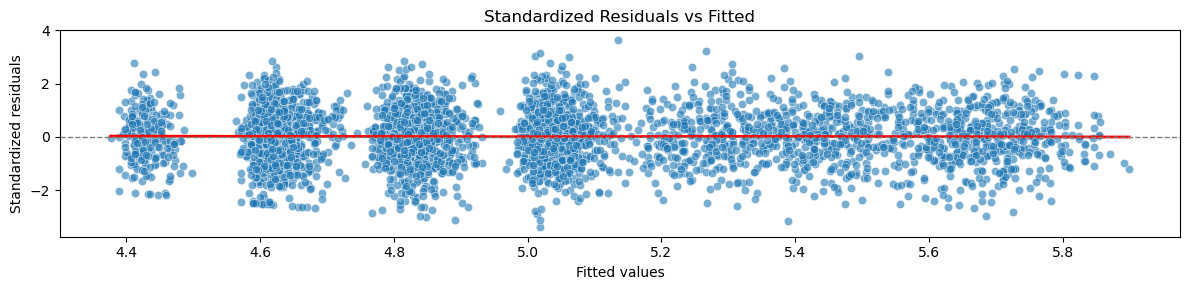

<Figure size 1200x300 with 0 Axes>

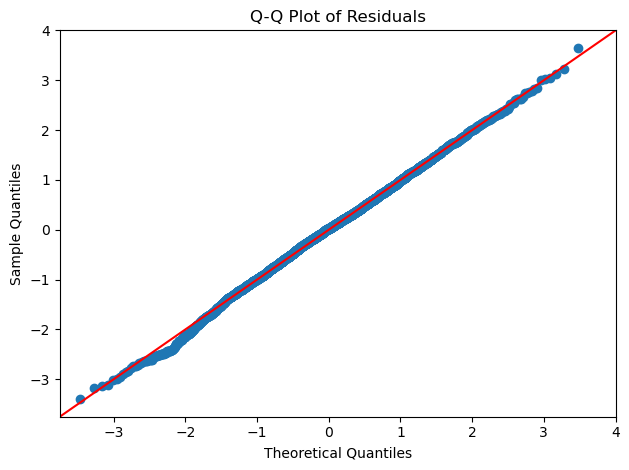

In [20]:
plot_diagnostics(model_log)

In [21]:
bool_cols = df_lr.select_dtypes(include='bool').columns
df_lr[bool_cols] = df_lr[bool_cols].astype(int)

In [22]:
bool_cols = X.select_dtypes(include='bool').columns
X[bool_cols] = X[bool_cols].astype(int)
calculate_vif(X, X.columns)

,feature,VIF
4,host_response_time_within an hour,4.890598
3,host_response_time_same day,4.211643
9,amenities_capacity,4.027501
0,min_stay_encoded,3.697017
1,property_type_Standard Apartment,3.264997
2,property_type_Tiny Studio,2.337497
5,season_peak,2.256186
6,season_shoulder,1.932826
7,cancellation_policy_moderate,1.540972
8,cancellation_policy_strict,1.412907


## Model 2: Decision Tree Model

In [23]:
df_tree = pd.read_csv('../data/df_cleaned_encoded.csv')

In [24]:
df_tree.head()

,guest_capacity,location_score,review_score,amenities_count,nightly_rate,years_as_host_log,cleaning_fee_log,bedroom_encoded,min_stay_encoded,property_type_Standard Apartment,property_type_Tiny Studio,host_response_time_same day,host_response_time_within an hour,season_peak,season_shoulder,cancellation_policy_moderate,cancellation_policy_strict
0,4,75.17,4.87,8,187.29,0.955511,3.110399,1,1,True,False,False,True,True,False,False,False
1,3,67.07,4.06,6,255.64,1.629241,3.671225,1,1,True,False,False,False,False,False,False,False
2,2,76.57,4.16,10,62.82,1.193922,3.938470,0,0,True,False,True,False,False,False,False,False
3,2,88.14,3.74,11,203.80,0.955511,3.593744,1,1,True,False,True,False,False,True,False,True
4,4,58.63,3.37,15,1000.00,0.641854,4.563306,2,3,False,False,True,False,True,False,False,True


In [25]:
df_tree['log_nightly_rate'] = np.log(df_tree['nightly_rate'])

In [26]:
X = df_tree.drop(columns=['nightly_rate', 'log_nightly_rate'])
X = X.astype({col: int for col in X.select_dtypes(include='bool').columns})
y = df_tree['log_nightly_rate']

In [27]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
# Build model
tree_model = DecisionTreeRegressor(max_depth=4, min_samples_leaf=20,  random_state=42)
tree_model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=4, min_samples_leaf=20, random_state=42)

In [29]:
# Evaluation

y_pred = tree_model.predict(X_test)
print("R2:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))

R2: 0.352862075843835
MAE: 0.3848848463846397


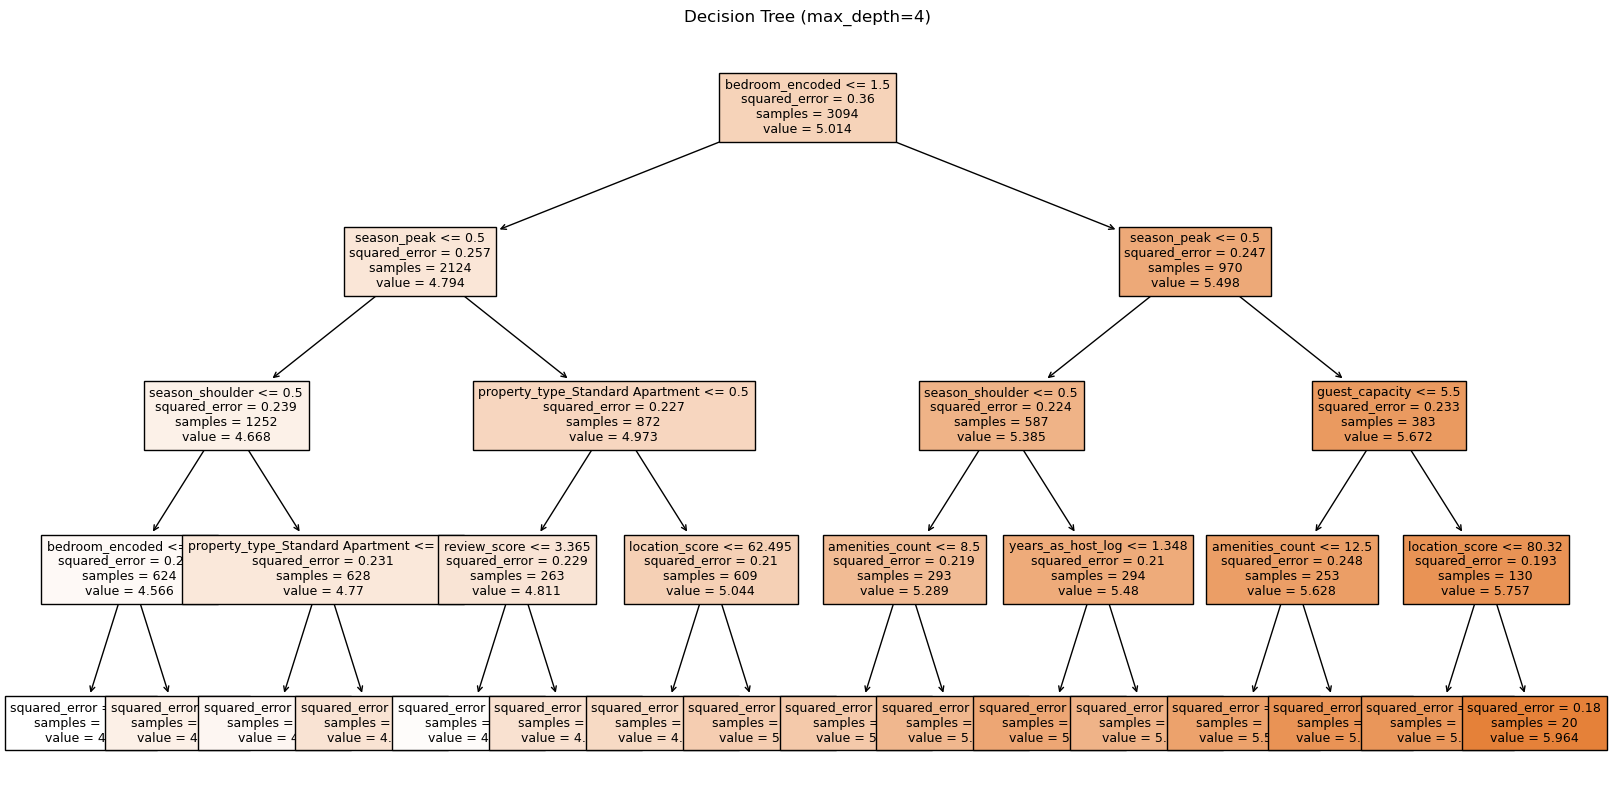

In [30]:
plt.figure(figsize=(20, 10))
plot_tree(tree_model, feature_names=X.columns, filled=True, fontsize=9)
plt.title("Decision Tree (max_depth=4)")
plt.show()

## Model Interpretation and Explanation

### Global Explanation - Feature Importance

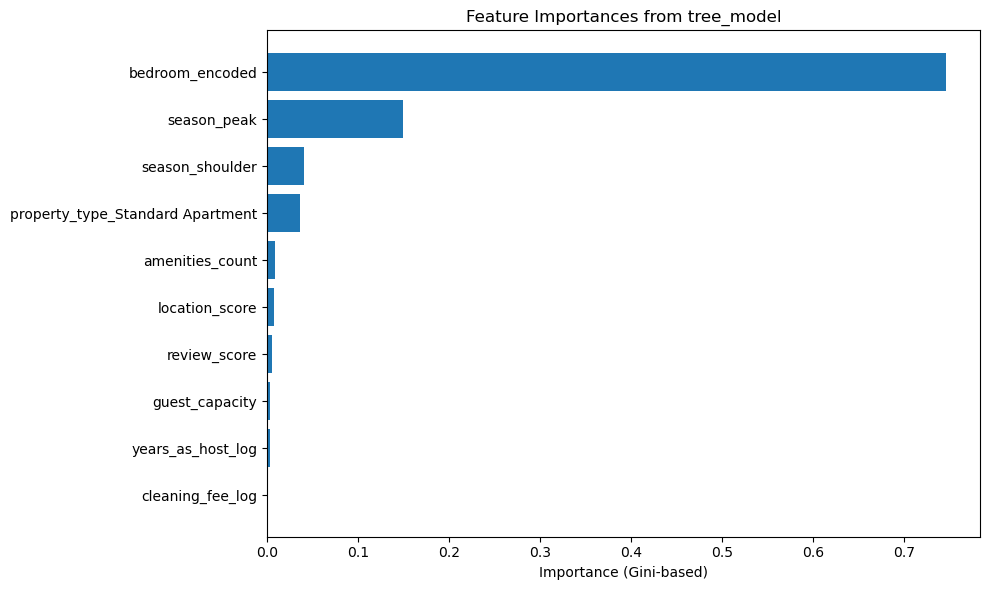

In [31]:
fi_values = tree_model.feature_importances_

fi_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': fi_values
}).sort_values(by='Importance', ascending=False)

fi_top10 = fi_df.head(10)

plt.figure(figsize=(10, 6))
plt.barh(fi_top10['Feature'][::-1], fi_top10['Importance'][::-1])
plt.title("Feature Importances from tree_model")
plt.xlabel("Importance (Gini-based)")
plt.tight_layout()
plt.show()

### Local Explanation - SHAP

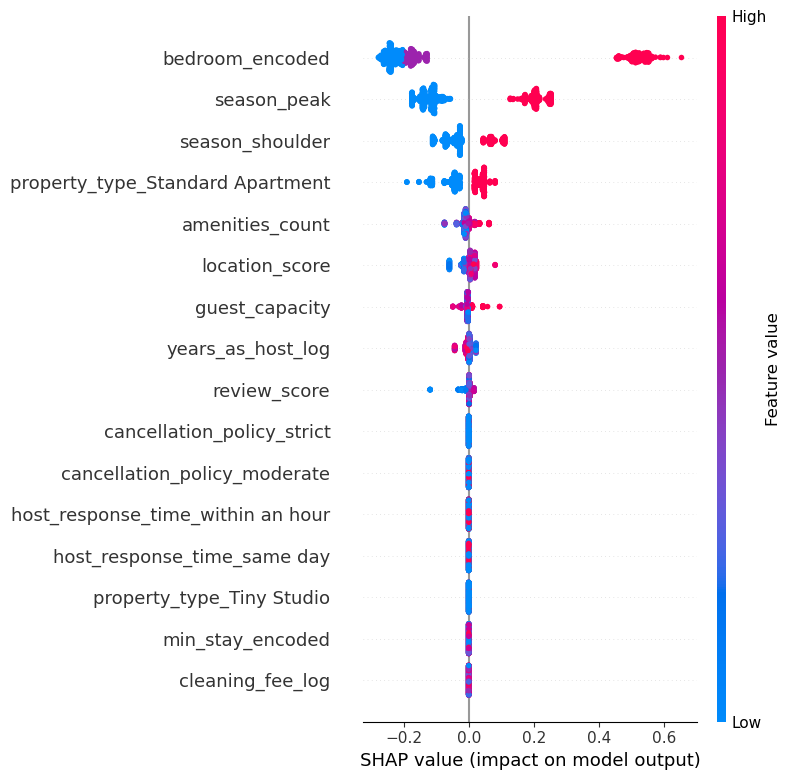

In [32]:
# SHAP summary report

explainer = shap.TreeExplainer(tree_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

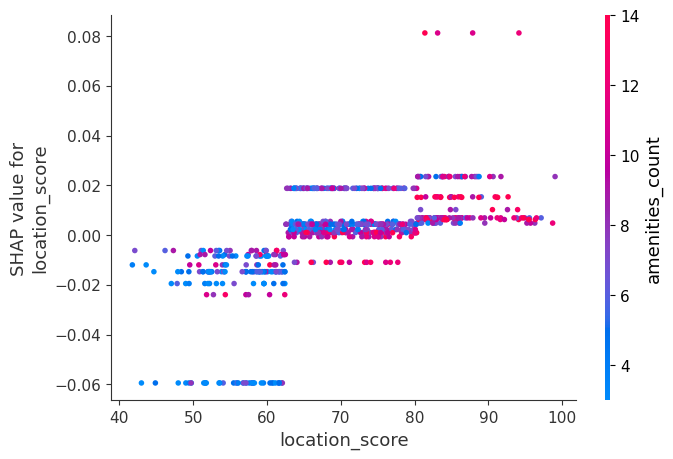

In [33]:
# Dependence plot
shap.dependence_plot("location_score", shap_values, X_test, interaction_index= "amenities_count")
